In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Tue_May_27_02:24:01_Pacific_Daylight_Time_2025
Cuda compilation tools, release 12.9, V12.9.86
Build cuda_12.9.r12.9/compiler.36037853_0
torch:  2.7 ; cuda:  cu128


roboflow: 1.2.1 ; supervision: 0.25.1 ; transformers: 4.53.2 ; pytorch_lightning: 2.5.2


### Download COCO JSON file of Sunflower Dataset


In [2]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="QnI44klNXIJV1kK3wG1Y")
project = rf.workspace("sunflower-detection").project("final-1yr0d")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


### Install ultralytics supervision and Roboflow. Then check for the CUDA

In [4]:
!pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.164  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
Setup complete  (16 CPUs, 15.4 GB RAM, 154.7/165.0 GB disk)


In [5]:
!pip install pycocotools tqdm


In [6]:
import os
import shutil
import json
from pathlib import Path
import yaml
from ultralytics import YOLO

## Create COCO data loaders

In [7]:
import os
import torch
import torchvision
from pathlib import Path
from transformers import DetrImageProcessor  # Or your desired processor

# ----------------------------------------------------------------------------
# Set dataset location and annotation name
# ----------------------------------------------------------------------------
DATASET_LOCATION = Path(r"D:\EWU\10th Semester\CSE475\LABS\ASSIGNMENT\Final-3")  # Use raw string to avoid issues
ANNOTATION_FILE_NAME = "_annotations.coco.json"

TRAIN_DIRECTORY = DATASET_LOCATION / "train"
VAL_DIRECTORY   = DATASET_LOCATION / "valid"
TEST_DIRECTORY  = DATASET_LOCATION / "test"

# ----------------------------------------------------------------------------
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 3956
Number of validation examples: 165
Number of test examples: 165


Image #2342


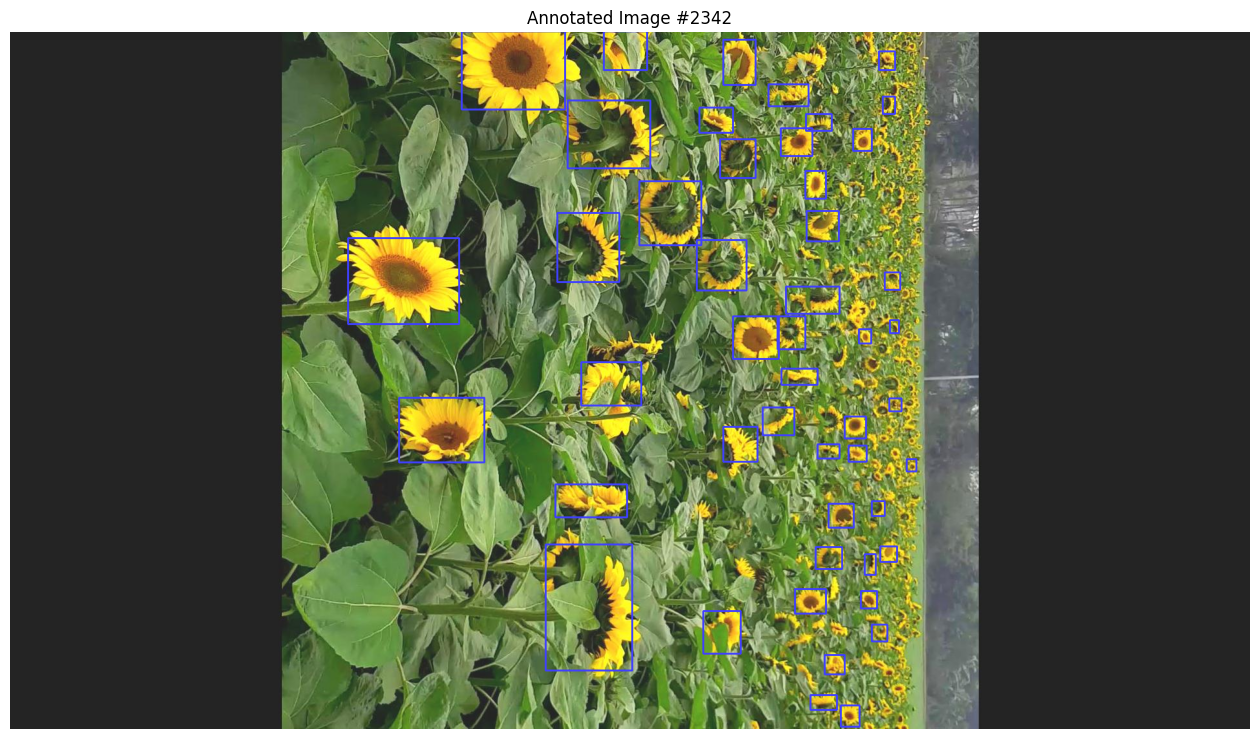

In [8]:
import os
import random
import cv2
import numpy as np
import supervision as sv
from supervision import Detections, BoxAnnotator
import matplotlib.pyplot as plt

# Select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f'Image #{image_id}')

# Load image and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib display

# Manually convert COCO annotations to supervision.Detections
xyxy = []
class_ids = []
confidences = []

for ann in annotations:
    x, y, w, h = ann['bbox']
    xyxy.append([x, y, x + w, y + h])
    class_ids.append(ann['category_id'] - 1)  # COCO class_id is 1-based, convert to 0-based
    confidences.append(1.0)  # Dummy confidence for ground truth

detections = Detections(
    xyxy=np.array(xyxy, dtype=np.float32),
    class_id=np.array(class_ids),
    confidence=np.array(confidences)
)

# Prepare labels mapping class_id -> class name
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

labels = [
    id2label[class_id + 1]  # convert back to COCO 1-based for label lookup
    for class_id in detections.class_id
]

# Annotate image with bounding boxes and labels
box_annotator = BoxAnnotator()
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

# Display annotated image using matplotlib
plt.figure(figsize=(16, 16))
plt.imshow(frame)
plt.axis('off')
plt.title(f"Annotated Image #{image_id}")
plt.show()


In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model with PyTorch Lightning

**NOTE:** Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [11]:
!pip install pytorch_lightning tensorboard
import tensorboard
from pytorch_lightning.loggers import TensorBoardLogger
%cd {HOME}

%load_ext tensorboard
%tensorboard --logdir lightning_logs/


[WinError 2] The system cannot find the file specified: '{HOME}'
d:\EWU\10th Semester\CSE475\LABS\ASSIGNMENT


Reusing TensorBoard on port 6006 (pid 1296), started 14:52:38 ago. (Use '!kill 1296' to kill it.)

In [22]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [23]:
outputs.logits.shape

torch.Size([4, 100, 4])

In [24]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 10

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WinError 2] The system cannot find the file specified: '{HOME}'
d:\EWU\10th Semester\CSE475\LABS\ASSIGNMENT



  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Epoch 9: 100%|██████████| 989/989 [11:33<00:00,  1.43it/s, v_num=3]        

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 989/989 [11:36<00:00,  1.42it/s, v_num=3]


In [25]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

Image #13
Ground Truth


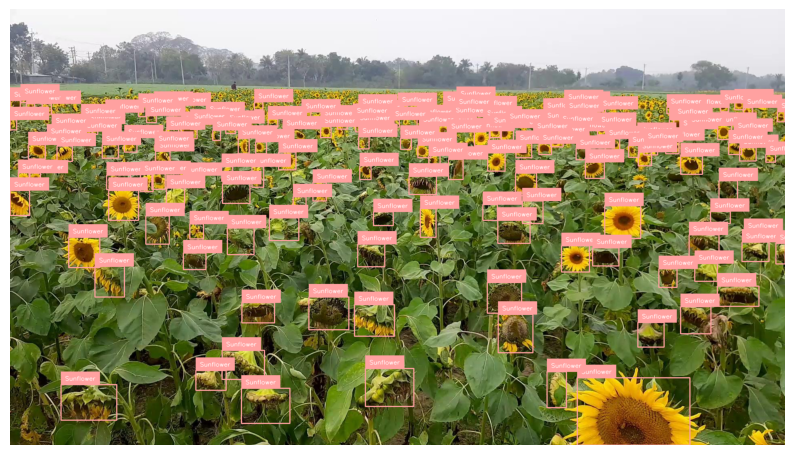

ValueError: too many values to unpack (expected 4)

In [27]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import supervision as sv  # pip install supervision

# ------------------------------------------------------------------
# Helper function: Convert COCO annotations to sv.Detections
def coco_annotations_to_detections(annotations):
    xyxy = []
    class_id = []
    for ann in annotations:
        x, y, w, h = ann['bbox']
        x1, y1, x2, y2 = x, y, x + w, y + h
        xyxy.append([x1, y1, x2, y2])
        class_id.append(ann['category_id'])
    return sv.Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        class_id=np.array(class_id)
    )

# ------------------------------------------------------------------
# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f"Image #{image_id}")

# load image and annotations
image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

# annotate ground truth
detections = coco_annotations_to_detections(annotations)
labels = [f"{id2label[class_id]}" for class_id in detections.class_id]
frame = box_annotator.annotate(scene=image.copy(), detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

print("Ground Truth")
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ------------------------------------------------------------------
# inference
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate model predictions
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)

# filter detections by confidence
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]

frame = box_annotator.annotate(scene=image.copy(), detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

print("Detections")
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



## Evaluation on test dataset

In [28]:
!pip install -q coco_eval

In [29]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [31]:
from coco_eval import CocoEvaluator
from tqdm import tqdm


import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


100%|██████████| 42/42 [00:38<00:00,  1.10it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [32]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from coco_eval import CocoEvaluator  # make sure this is implemented or imported
# You must also have `prepare_for_coco_detection` defined earlier

def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou  # [N,M]

# Initialization
evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

y_true_all = []
y_pred_all = []

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch.get("pixel_mask", None)
    if pixel_mask is not None:
        pixel_mask = pixel_mask.to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
        if pixel_mask is not None:
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        else:
            outputs = model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # Prepare COCO format predictions
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

    # For classification metrics, do matching by IoU threshold 0.5
    for i in range(len(results)):
        preds = results[i]
        gts = labels[i]

        pred_boxes = preds["boxes"].cpu()          # [Np, 4]
        pred_labels = preds["labels"].cpu()        # [Np]
        gt_boxes = gts["boxes"].cpu()               # [Ng, 4]

        # Safely get gt labels
        if "labels" in gts:
            gt_labels = gts["labels"].cpu()
        elif "class_labels" in gts:
            gt_labels = gts["class_labels"].cpu()
        elif "category_ids" in gts:
            gt_labels = gts["category_ids"].cpu()
        else:
            try:
                gt_labels = torch.tensor([ann['category_id'] for ann in gts])
            except Exception as e:
                print(f"Could not extract gt labels for sample {i} in batch {idx}: {e}")
                gt_labels = torch.tensor([])

        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue

        ious = box_iou(pred_boxes, gt_boxes)  # [Np, Ng]

        iou_thresh = 0.5
        matched_gt = -torch.ones(len(pred_boxes), dtype=torch.long)

        for pidx in range(len(pred_boxes)):
            iou_row = ious[pidx]
            max_iou, gtidx = torch.max(iou_row, dim=0)
            if max_iou >= iou_thresh:
                matched_gt[pidx] = gtidx

        for pidx, gtidx in enumerate(matched_gt):
            if gtidx == -1:
                continue
            y_pred_all.append(pred_labels[pidx].item())
            y_true_all.append(gt_labels[gtidx].item())

print(f"Collected {len(y_true_all)} matched pairs.")

# COCO evaluation (mAP)
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

# Prepare class info
class_ids_sorted = sorted(TEST_DATASET.coco.cats.keys())
class_names = [TEST_DATASET.coco.cats[k]['name'] for k in class_ids_sorted]

if len(y_true_all) == 0 or len(y_pred_all) == 0:
    print("No matched predictions found. Skipping classification report and confusion matrix.")
else:
    print("\nClassification Report:")
    print(classification_report(
        y_true_all,
        y_pred_all,
        labels=class_ids_sorted,
        target_names=class_names,
        zero_division=0
    ))

    cm = confusion_matrix(y_true_all, y_pred_all, labels=class_ids_sorted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


Running evaluation...


100%|██████████| 42/42 [00:37<00:00,  1.13it/s]

Collected 0 matched pairs.
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Recall     (AR) 

## Save and load model

In [34]:
HOME = "D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT"  # or your actual path
MODEL_PATH = os.path.join(HOME, 'DETR-model')
model.model.save_pretrained(MODEL_PATH)
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      